In [160]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing import image
%matplotlib inline

In [161]:
#normalize the scale of color to 0-1 range
train_datagen = image.ImageDataGenerator(featurewise_center = True, rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'data',
        class_mode = None,
        target_size=(64, 512),
        batch_size = 500,
        shuffle = False)

Found 1500 images belonging to 1 classes.


In [162]:
count = 0
all_img = np.empty((0,64,512,3))
for X_batch in train_generator:
    all_img = np.concatenate([all_img,X_batch])
    count += 1
    if count >= 3:
        break

In [163]:
#all_img[0].shape
print all_img[0].shape

(64, 512, 3)

In [193]:
def plot_imgs(img):
    plt.imshow(img.reshape(64, 512, 3))
    plt.axis('off')
    plt.show()

In [200]:
idx = 0
train_1 = []
train_2 =[]
target = []

for img in all_img:
    if idx % 3 == 0:
        train_1.append(img)
    elif idx % 3 == 1:
        train_2.append(img)
    else:
        target.append(img) 
    idx +=1

In [201]:
train_1 = np.array(train_1)
train_2 = np.array(train_2)
target = np.array(target)

In [198]:
from keras import losses
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.losses import mean_squared_error
from keras.callbacks import TensorBoard,History

In [199]:
def combined_loss(y_true, y_pred):
    return losses.mean_squared_error(y_true, y_pred)+ losses.binary_crossentropy(y_true, y_pred)

In [218]:
input_img = Input(shape=(64, 512, 3))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((1, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2), padding='same')(x)

encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((1, 2))(encoded)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((1, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

decoded  = Conv2D(3, (3, 3), activation='sigmoid',padding='same')(x)

In [219]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam',loss=combined_loss,metrics=['mse'])

In [ ]:
np.random.seed(6)
shuffled_index = np.arange(500)
np.random.shuffle(shuffled_index)
train_index = shuffled_index[:400]
test_index = shuffled_index[400:]

X_train_1 = train_1[train_index]
X_test_1 = train_1[test_index]

X_train_2 = train_2[train_index]
X_test_2 = train_2[test_index]

Y_train = target[train_index]
Y_test = target[test_index]

In [ ]:
autoencoder.fit(X_train_1,Y_train, epochs=100,batch_size = 64,shuffle=True,
                validation_data=(X_test_1, Y_test))

Train on 400 samples, validate on 100 samples
Epoch 1/100
400/400 [==============================] - 45s - loss: 0.7646 - mean_squared_error: 0.0734 - val_loss: 0.7572 - val_mean_squared_error: 0.0745
Epoch 2/100
400/400 [==============================] - 44s - loss: 0.7322 - mean_squared_error: 0.0627 - val_loss: 0.7023 - val_mean_squared_error: 0.0568
Epoch 3/100
400/400 [==============================] - 47s - loss: 0.6800 - mean_squared_error: 0.0466 - val_loss: 0.6667 - val_mean_squared_error: 0.0458
Epoch 4/100
400/400 [==============================] - 48s - loss: 0.6555 - mean_squared_error: 0.0389 - val_loss: 0.6612 - val_mean_squared_error: 0.0445
Epoch 5/100
400/400 [==============================] - 45s - loss: 0.6487 - mean_squared_error: 0.0371 - val_loss: 0.6566 - val_mean_squared_error: 0.0430
Epoch 6/100
384/400 [===========================>..] - ETA: 1s - loss: 0.6456 - mean_squared_error: 0.0363

In [205]:
Y_pred = autoencoder.predict(X_test_1[:100])

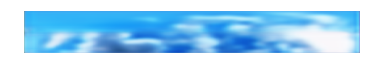

In [217]:
plot_imgs(Y_pred[5])